In [1]:
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.utils import np_utils
from keras.layers import Input
from keras.models import Model

print('done')

Using TensorFlow backend.


done


In [2]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
print('done')

done


In [3]:
# load data
print('Loading dataset...')
from my_dataset_loaders import load_dataset_RGB
X1_train, X2_train, X3_train, y_train, X1_test, X2_test, X3_test, y_test = load_dataset_OF_BW()
print('Dataset loaded.')

Loading dataset...
pos files:  2002
neg files:  2001
Dataset loaded. 


In [ ]:
print(X1_train.shape)
import cv2
cv2.imshow("Image X1", X1_train[2,:,:,:])
cv2.imshow("Image X2", X2_train[2,:,:,:])
cv2.imshow("Image X3", X3_train[2,:,:,:])
print(y_train[3])
cv2.waitKey(0)

In [ ]:
import cv2
im  = cv2.read('/home/himanshu/Pictures/1.jpg')
cv2.imshow("Image X3", im)
cv2.waitKey(0)

In [4]:
# Define the vision modules

s_input = Input(shape=(96, 128, 3))
# x = Conv2D(64, (3, 3), padding='same', kernel_constraint=maxnorm(3))(s_input)
x = Conv2D(64, (3, 3), padding='same', kernel_constraint=maxnorm(3))(s_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_constraint=maxnorm(3))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_constraint=maxnorm(3))(x)
out = Dropout(0.5)(x)
print('done')

done


In [5]:
vision_model = Model(s_input, out)
print('done')

done


In [6]:
# Then define the input-apart model
s_a = Input(shape=(96, 128, 3))
s_b = Input(shape=(96, 128, 3))
s_c = Input(shape=(96, 128, 3))
print('done')

done


In [7]:
# The vision model will be shared
out_a = vision_model(s_a)
out_b = vision_model(s_b)
out_c = vision_model(s_c)
print('done')

done


In [8]:
import keras
concatenated = keras.layers.concatenate([out_a, out_b, out_c])
out = Dense(1, activation='sigmoid')(concatenated)
print('done')

done


In [9]:
classification_model = Model([s_a, s_b, s_c], out)
print('done')

done


In [10]:
# Compile model

epochs = 30
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
classification_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(classification_model.summary())
print('done')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 128, 3)   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 96, 128, 3)   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 96, 128, 3)   0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 256)          6793856     input_2[0][0]                    
                                                                 input_3[0][0]                    
          

In [11]:
# Fit the model

from keras.callbacks import CSVLogger
csv_logger = CSVLogger('./evaluation/log.csv', append=True, separator=';')

history = classification_model.fit([X1_train, X2_train, X3_train], y_train, validation_data=([X1_test, X2_test, X3_test], y_test), epochs=epochs, batch_size=32, verbose=1, callbacks=[csv_logger])
print('done')

Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 41s 51ms/step - loss: 0.8525 - acc: 0.5375 - val_loss: 0.7006 - val_acc: 0.5000
Epoch 2/30
800/800 [==============================] - 34s 42ms/step - loss: 0.7013 - acc: 0.5288 - val_loss: 0.7200 - val_acc: 0.5050
Epoch 3/30
800/800 [==============================] - 34s 42ms/step - loss: 0.7019 - acc: 0.4913 - val_loss: 0.6884 - val_acc: 0.5400
Epoch 4/30
800/800 [==============================] - 34s 42ms/step - loss: 0.6887 - acc: 0.5363 - val_loss: 0.6945 - val_acc: 0.5750
Epoch 5/30
800/800 [==============================] - 34s 42ms/step - loss: 0.6945 - acc: 0.5463 - val_loss: 0.6983 - val_acc: 0.5550
Epoch 6/30
800/800 [==============================] - 35s 44ms/step - loss: 0.6754 - acc: 0.5775 - val_loss: 0.7186 - val_acc: 0.5250
Epoch 7/30
800/800 [==============================] - 34s 42ms/step - loss: 0.6560 - acc: 0.5787 - val_loss: 0.7387 - val_acc: 0.4950
Epoch 8/30
800/8

In [12]:
# Save model architecture and weights

# serialize model to JSON
model_json = classification_model.to_json()
with open("./evaluation/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
classification_model.save_weights("./evaluation/model.h5")
print("Model saved to disk")

Model saved to disk


In [13]:
# Final evaluation of the model

scores = classification_model.evaluate([X1_test, X2_test, X3_test], y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 43.00%


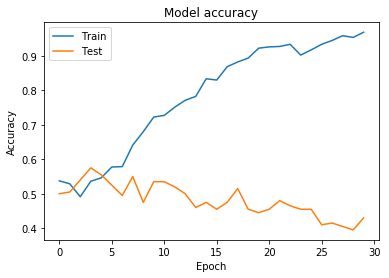

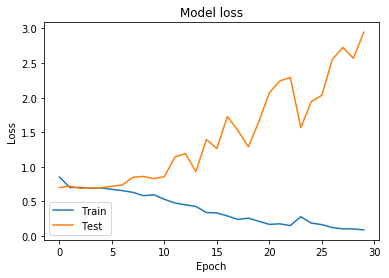

In [14]:
# Visualize the training progress     # keep verbose=1 in model.fit()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, draw

# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
plt.savefig('./evaluation/Acc.eps', format='eps', dpi=400)

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower left')
# plt.show()
plt.savefig('./evaluation/Loss.eps', format='eps', dpi=400)

In [16]:
# Load the model architecture and weights

from keras.models import model_from_json

# load json and create model
json_file = open("./evaluation/model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./evaluation/model.h5")
classification_model = loaded_model
print("Model loaded from disk")

Model loaded from disk


In [ ]:
import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model

tweet_a = Input(shape=(280, 256))
tweet_b = Input(shape=(280, 256))

In [ ]:
# This layer can take as input a matrix
# and will return a vector of size 64
shared_lstm = LSTM(64)

# When we reuse the same layer instance
# multiple times, the weights of the layer
# are also being reused
# (it is effectively *the same* layer)
encoded_a = shared_lstm(tweet_a)
encoded_b = shared_lstm(tweet_b)

# We can then concatenate the two vectors:
merged_vector = keras.layers.concatenate([encoded_a, encoded_b], axis=-1)

# And add a logistic regression on top
predictions = Dense(1, activation='sigmoid')(merged_vector)

# We define a trainable model linking the
# tweet inputs to the predictions
model = Model(inputs=[tweet_a, tweet_b], outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit([data_a, data_b], labels, epochs=10)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model

# First, define the vision modules
digit_input = Input(shape=(27, 27, 1))
x = Conv2D(64, (3, 3))(digit_input)
x = Conv2D(64, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
out = Flatten()(x)

vision_model = Model(digit_input, out)

# Then define the tell-digits-apart model
digit_a = Input(shape=(27, 27, 1))
digit_b = Input(shape=(27, 27, 1))

# The vision model will be shared, weights and all
out_a = vision_model(digit_a)
out_b = vision_model(digit_b)

concatenated = keras.layers.concatenate([out_a, out_b])
out = Dense(1, activation='sigmoid')(concatenated)

classification_model = Model([digit_a, digit_b], out)